In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [55]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem import WordNetLemmatizer
import string

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [56]:
df = pd.read_csv("GuestSatisfactionPrediction.csv")

C:\Users\dell\AppData\Local\Temp\ipykernel_12768\2486922539.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("GuestSatisfactionPrediction.csv")


In [57]:
# Fill text fields with empty string
columns = ['summary', 'space', 'description', 'neighborhood_overview',
                'transit', 'access', 'interaction', 'house_rules']
df[columns] = df[columns].fillna('No information provided')

In [58]:
# Fill categorical with mode
categorical_cols = [ 'host_location', 'host_response_time', 'host_neighbourhood',
                    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
                     'state', 'market']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [59]:
# Safely strip '%' and convert to float
df['host_response_rate'] = df['host_response_rate'].astype(str).str.rstrip('%')
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')
df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())

In [60]:
# Clean 'zipcode': keep only the first 5 digits
df['zipcode'] = df['zipcode'].astype(str).str.extract(r'(\d{5})')
df['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')

# Fill all numeric columns with median
numeric_cols_median = ['zipcode', 'bathrooms', 'bedrooms', 'beds', 'host_listings_count',
                       'host_total_listings_count']

for col in numeric_cols_median:
    df[col] = df[col].fillna(df[col].median())

In [61]:
# Optional numeric financials
df['security_deposit'] = df['security_deposit'].fillna(0)
df['cleaning_fee'] = df['cleaning_fee'].fillna(0)

In [62]:
# Columns with only 1 missing value
single_missing = df.columns[df.isnull().sum() == 1]
for col in single_missing:
    df[col] = df[col].fillna(df[col].mode()[0] if df[col].dtype == 'O' else df[col].median())

In [65]:
if 'neighbourhood' in df.columns:
    df.drop('neighbourhood', axis=1, inplace=True)


# Build the summary table
summary = pd.DataFrame({
    'Feature': df.columns,
    'Data Type': df.dtypes.values,
    'Missing Values': df.isnull().sum().values
})

# Sort by number of missing values (descending)
summary = summary.sort_values(by='Missing Values', ascending=False).reset_index(drop=True)

# Display all 69 rows
pd.set_option('display.max_rows', None)
print(summary)

                             Feature Data Type  Missing Values
0               host_acceptance_rate   float64            8724
1                      thumbnail_url   float64            8724
2                        square_feet   float64            8618
3                              notes    object            3509
4                         host_about    object            2462
5                               beds   float64               0
6                     price_per_stay    object               0
7                      nightly_price    object               0
8                          amenities    object               0
9                           bed_type    object               0
10                          bedrooms   float64               0
11                      cleaning_fee    object               0
12                         bathrooms   float64               0
13                      accommodates     int64               0
14                         room_type    object         

In [66]:
def get_text_columns(df, sample_ratio=0.3, min_avg_len=5, min_unique=3):
    text_columns = []

    for col in df.columns:
        sample = df[col].dropna().sample(frac=min(sample_ratio, 1.0), random_state=42)

        is_text = sample.apply(lambda x: isinstance(x, str) and not x.isnumeric()).mean() > 0.8
        avg_len = sample.apply(lambda x: len(x) if isinstance(x, str) else 0).mean()
        num_unique = df[col].nunique()

        if is_text and avg_len > min_avg_len and num_unique >= min_unique:
            text_columns.append(col)

    return text_columns

# Convert currency column to float
df['extra_people'] = df['extra_people'].replace(r'[\$,]', '', regex=True).astype(float)
df['nightly_price'] = df['nightly_price'].replace(r'[\$,]', '', regex=True).astype(float)
df['price_per_stay'] = df['price_per_stay'].replace(r'[\$,]', '', regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].replace(r'[\$,]', '', regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].replace(r'[\$,]', '', regex=True).astype(float)

# Convert date columns to datetime
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

text_columns = get_text_columns(df)
print("Text columns in the DataFrame:", text_columns)


Text columns in the DataFrame: ['listing_url', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_url', 'host_name', 'host_location', 'host_about', 'host_response_time', 'host_neighbourhood', 'street', 'neighbourhood_cleansed', 'city', 'market', 'smart_location', 'country', 'property_type', 'room_type', 'bed_type', 'amenities', 'cancellation_policy']


In [67]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Explicitly tokenize with 'english' language
    tokens = word_tokenize(text, language='english')
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

for col in text_columns:
    df[f"{col}_cleaned"] = df[col].apply(preprocess_text)


In [68]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.isotonic import spearmanr

def calculate_text_importance(df, text_columns, target_col, max_features=1000):
    importance = {}
    
    for col in text_columns:
        cleaned_col = f"{col}_cleaned"
        
        # Compute TF-IDF
        vectorizer = TfidfVectorizer(max_features=max_features)
        try:
            tfidf = vectorizer.fit_transform(df[cleaned_col])
        except ValueError:  # Skip empty columns
            importance[col] = 0.0
            continue
        
        # Compute variance of TF-IDF scores
        variance = np.array(tfidf.todense()).var(axis=0).mean()
        
        # Compute correlation with target (using Spearman's rank correlation)
        correlations = []
        for i in range(tfidf.shape[1]):
            term_scores = tfidf[:, i].toarray().flatten()
            corr, _ = spearmanr(term_scores, df[target_col])
            correlations.append(abs(corr))
        
        avg_correlation = np.mean(correlations) if correlations else 0.0
        
        # Combine metrics (variance + correlation)
        importance[col] = (variance + avg_correlation) / 2  
        
    return importance
importance_scores = calculate_text_importance(df, text_columns, target_col = 'review_scores_rating',max_features=1000)


In [69]:
def select_top_columns(importance_scores, min_score=0.01):
    selected = [col for col, score in importance_scores.items() if score > min_score]
    return selected

top_columns = select_top_columns(importance_scores, min_score=0.01)
print("Final Selected Columns:", top_columns)
print("Importance Scores:", importance_scores)

Final Selected Columns: ['house_rules', 'host_about', 'host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy']
Importance Scores: {'listing_url': 0.004941775028799914, 'name': 0.006510086760201127, 'summary': 0.007829907513541946, 'space': 0.008227829147494972, 'description': 0.008281709062476054, 'neighborhood_overview': 0.0076537726415946365, 'notes': 0.008227887816291237, 'transit': 0.00706968050902371, 'access': 0.007332851259169266, 'interaction': 0.00767379527244509, 'house_rules': 0.012933784077946682, 'host_url': 0.006306402844358697, 'host_name': 0.006306452777014354, 'host_location': 0.006210530313872332, 'host_about': 0.010068383323812826, 'host_response_time': 0.031223403580563712, 'host_neighbourhood': 0.009564806138785999, 'street': 0.008938513968836275, 'neighbourhood_cleansed': 0.011113987014339634, 'city': 0.009584859329434182, 'market': 0.008056046965746584, 'smart_location': 0.00915122357008858, 'country': 0.006637925036675

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def plot_importance_scores(importance_scores, top_columns):
    if not top_columns:
        print("No columns to plot")
        return

    scores = {col: importance_scores[col] for col in top_columns if col in importance_scores}
    columns = list(scores.keys())
    values = list(scores.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=values, y=columns)
    plt.title("Top Text Columns by Importance Score")
    plt.xlabel("Importance Score")
    plt.ylabel("Text Column")
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

def plot_word_clouds(df, top_columns):
    if not top_columns:
        print("No columns to plot")
        return

    plt.figure(figsize=(15, 5))

    for i, col in enumerate(top_columns, 1):
        cleaned_col = f"{col}_cleaned"
        if cleaned_col not in df.columns:
            continue

        text_data = df[cleaned_col].dropna().astype(str)
        text = ' '.join(text_data)

        if not text.strip():
            continue

        try:
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                min_word_length=3,
                max_words=200
            ).generate(text)
        except ValueError:
            continue

        plt.subplot(1, len(top_columns), i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud: {col}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_tfidf_variance(df, top_columns, max_features=20):
    if not top_columns:
        print("No columns to plot")
        return

    plt.figure(figsize=(12, 6))

    for col in top_columns:
        cleaned_col = f"{col}_cleaned"
        if cleaned_col not in df.columns:
            continue

        text_data = df[cleaned_col].dropna().astype(str)
        if text_data.empty:
            continue

        vectorizer = TfidfVectorizer(max_features=max_features)
        tfidf = vectorizer.fit_transform(text_data)
        variance = tfidf.toarray().var(axis=0)

        plt.plot(variance, label=col, marker='o')

    plt.title("TF-IDF Variance per Feature")
    plt.xlabel("Feature Index")
    plt.ylabel("Variance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_target_correlation(df, top_columns, target_col, max_features=10):
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found")
        return

    if not top_columns:
        print("No columns to plot")
        return

    target = pd.to_numeric(df[target_col], errors='coerce').fillna(0)

    plt.figure(figsize=(12, 6))

    for col in top_columns:
        cleaned_col = f"{col}_cleaned"
        if cleaned_col not in df.columns:
            continue

        text_data = df[cleaned_col].dropna().astype(str)
        if text_data.empty:
            continue

        vectorizer = TfidfVectorizer(max_features=max_features)
        tfidf = vectorizer.fit_transform(text_data)

        correlations = []
        for i in range(tfidf.shape[1]):
            term_scores = tfidf[:, i].toarray().flatten()
            corr = np.corrcoef(term_scores, target[:len(term_scores)])[0, 1]
            correlations.append(abs(corr))

        plt.plot(correlations, label=col, marker='o')

    plt.title(f"Correlation with Target: {target_col}")
    plt.xlabel("Term Index")
    plt.ylabel("Absolute Correlation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


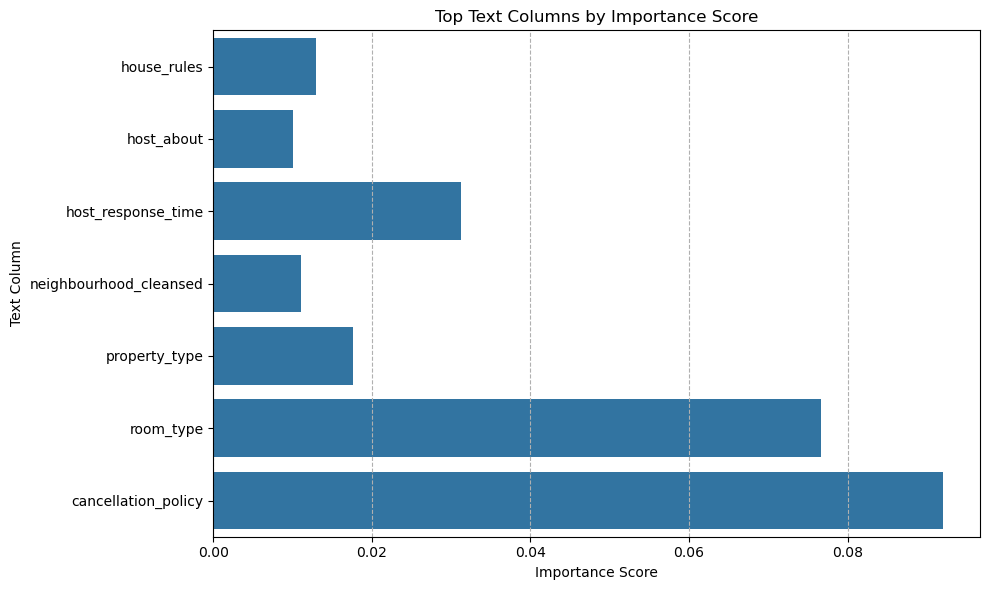

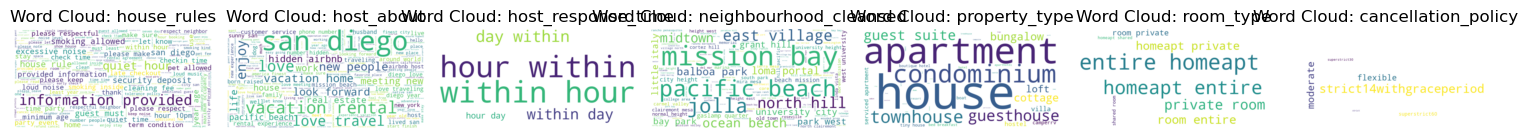

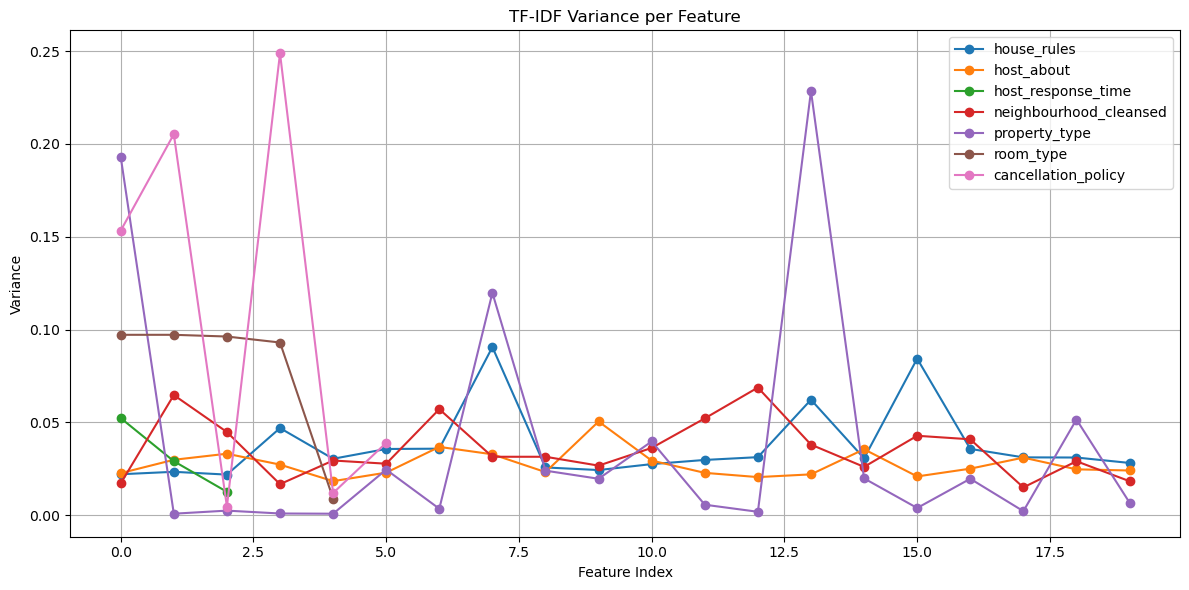

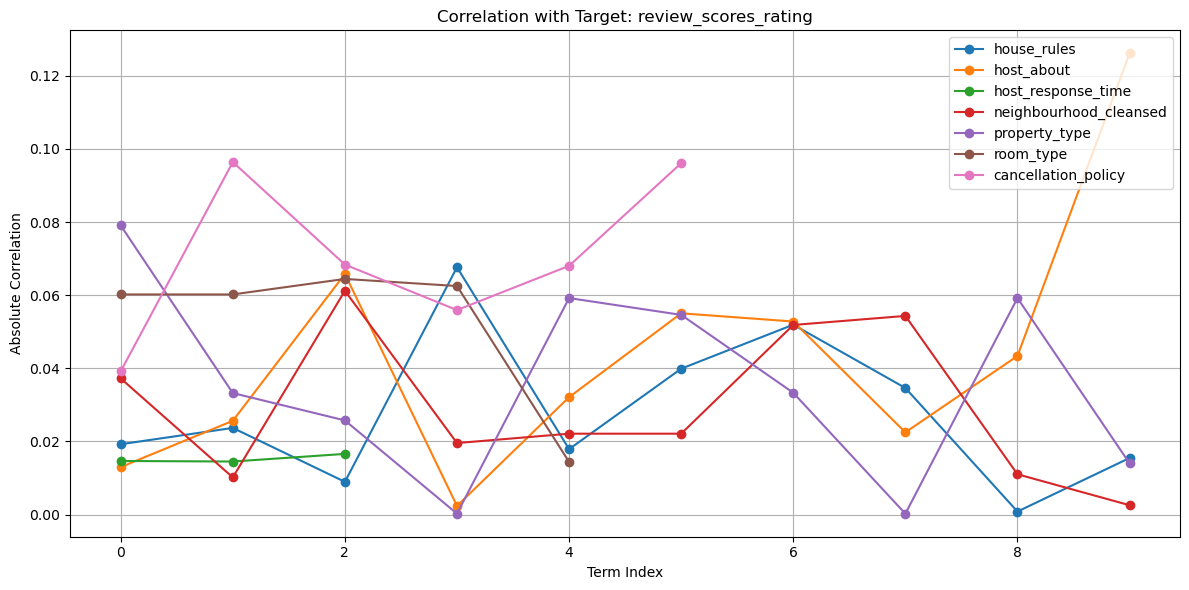

In [71]:
# Text Columns Dashboard
def visualize_all(df, importance_scores, top_columns, target_col):
    # Bar chart
    plot_importance_scores(importance_scores, top_columns)
    
    # Word clouds
    plot_word_clouds(df, top_columns)
    
    # TF-IDF variance
    plot_tfidf_variance(df, top_columns)
    
    # Target correlation
    plot_target_correlation(df, top_columns, target_col)

# Example usage
visualize_all(df, importance_scores, top_columns, target_col='review_scores_rating')